In [1]:
import pandas as pd
data_df = pd.read_csv('train.csv')
data_df.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np 
random_state=1
train_df, test_df = train_test_split(data_df, test_size=5000, random_state=random_state)
train_df, valid_df = train_test_split(train_df, test_size=10000, random_state=random_state)
print('train data size: ', len(train_df))
print('valid data size: ', len(valid_df))
print('test  data size: ', len(test_df))

X_train, Y_train = (np.array(train_df['filename']), np.array(train_df['label']))
X_valid, Y_valid = (np.array(valid_df['filename']), np.array(valid_df['label']))
X_test, Y_test = (np.array(test_df['filename']), np.array(test_df['label']))

print(X_train[0:4])
print(Y_train[0:4])

train data size:  85000
valid data size:  10000
test  data size:  5000
['train/95642.jpg' 'train/18183.jpg' 'train/33334.jpg' 'train/35926.jpg']
['5-9*7=-58' '8-(9-9)=8' '2+3-5=0' '4-4*2=-4']


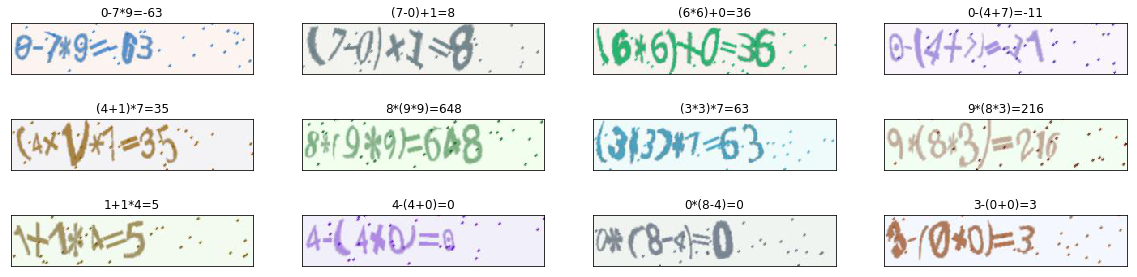

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300, 64))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(20,5))
for i in range(12):
    label = Y_test[i]
    ax = fig.add_subplot(3,4, i+1,xticks=[],yticks=[], title=label)
    visualize_img(X_test[i], ax)

In [ ]:
# img = cv2.imread(X_train[0])
# print(img.shape)
# print(img)

In [ ]:
# test = map(lambda x: x **2, range(9))
# print(test)
# for i in test:
#     print(i) 
# help(list)

In [4]:
from collections import defaultdict

char_counter= defaultdict(lambda: 0)

def count(x):
    for i in x:
        char_counter[i] += 1

labels = np.array(data_df['label'])

list(map(count, labels))
print(char_counter)
print('max lenght: ', np.max(list(map(lambda x: len(x), labels))))

defaultdict(<function <lambda> at 0x7f4dcea92b70>, {'(': 66487, '0': 46522, '+': 66517, ')': 66487, '9': 37251, '=': 100000, '*': 66668, '8': 40008, '6': 42535, '7': 38880, '1': 64228, '5': 42278, '4': 45867, '-': 89396, '3': 44442, '2': 51072})
max lenght:  11


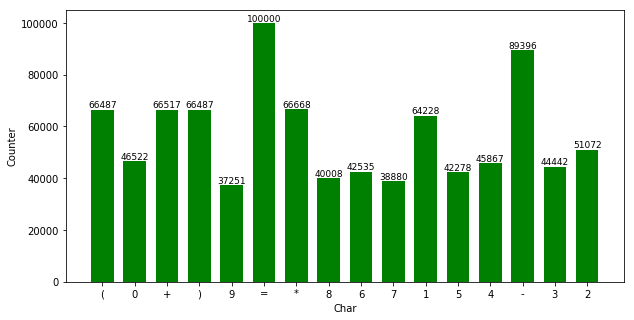

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.bar(char_counter.keys(), char_counter.values(), width=0.7, color='g')
plt.ylabel('Counter')
plt.xlabel('Char')
for key, value in char_counter.items():
    plt.text(key,value,'%d' % value, ha='center', va='bottom', fontsize=9)
    

In [6]:
char_vector = np.array(['0','1','2','3','4','5','6','7','8','9','(',')','+',"-",'*','='])
# print(len(char_counter.keys()))
# print(len(char_vector))
print(char_vector.shape)

img_w = 300
img_h = 64
n_classes = len(char_vector) + 1 # add one to present other class
max_exp_len = 11


def label_to_char(label):
    return char_vector[label]

def char_to_label(char):
    return np.argwhere(char_vector == char)[0][0]

def labels_to_expression(labels):
    return ''.join(list(map(lambda x: label_to_char(x),labels)))

def expression_to_labels(expression):
    return list(map(lambda x: char_to_label(x),list(expression)))

def path_to_tensor(img_path, img_w, img_h):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_w, img_h))
    img = img.T
    img = img.astype(np.float32)
    img = (img / 255.0) * 2 - 1.0
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    return img

def paths_to_tensor(img_paths, img_w, img_h):
    list_of_tensors = [path_to_tensor(path, img_w, img_h)  for path in img_paths]
    return np.vstack(list_of_tensors)
    
    
l1 = char_to_label('=')
c1 = label_to_char(l1)
print(l1)
print(c1)

ls1 = [1,12, 7, 14, 9, 15, 1, 2]
ex1 = labels_to_expression(ls1)
ls2 = expression_to_labels(ex1)
print(ex1)
print(ls2)

tensor_t = path_to_tensor(X_train[0], img_w, img_h)
print(tensor_t.shape)
# print(img_test)
tensors_list = paths_to_tensor(X_test, img_w, img_h)
print(tensors_list.shape)


(16,)
15
=
1+7*9=12
[1, 12, 7, 14, 9, 15, 1, 2]
(1, 300, 64, 1)
(5000, 300, 64, 1)


In [7]:
import cv2
import random

class TensorGenerator:
    
    def __init__(self, img_paths, expressions, img_w, img_h, batch_size, max_exp_len):
        self.img_paths = img_paths
        self.expressions = expressions
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.max_exp_len = max_exp_len
        self.n = len(img_paths)
        self.indexes = list(range(self.n))
        self.next_index = 0
    
    def next_sample(self):
        index = self.indexes[self.next_index]
        self.next_index += 1
        if self.next_index >= self.n:
            self.next_index = 0
            random.shuffle(self.indexes)
        path = self.img_paths[index]
        labels = expression_to_labels(self.expressions[index])
        img = path_to_tensor(path, self.img_w, self.img_h)
        return img, labels
        
    def next_batch(self):
        while True:
            
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_exp_len])
            
            input_length = np.ones([self.batch_size, 1]) * 37 # equal to the model define before push to rnn
            label_length = np.zeros([self.batch_size, 1])
            
            for i in range(self.batch_size):
                img, labels = self.next_sample()
                X_data[i] = img[0]
                Y_data[i][0: len(labels)] = labels
                label_length[i] = len(labels)
#                 print(labels_to_expression(labels))
                
            inputs = {
                'the_inputs': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            
            outputs = {
                'ctc':np.zeros([self.batch_size])
            }
#             print(inputs)
            
            yield(inputs, outputs)

In [8]:
generator_test = TensorGenerator(X_train, Y_train, img_w, img_h, 20, 11)
f = generator_test.next_batch()
r = f.__next__()
# r = r[0]['the_inputs'].shape
print(r)

({'the_inputs': array([[[[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.95294118],
         [0.95294118],
         [0.98431373]],

        [[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.96078432],
         [0.96078432],
         [0.98431373]],

        [[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.99215686],
         [0.98431373],
         [0.95294118]],

        ...,

        [[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.96862745],
         [0.96862745],
         [0.96862745]],

        [[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.96862745],
         [0.96862745],
         [0.96862745]],

        [[0.96862745],
         [0.96862745],
         [0.96862745],
         ...,
         [0.96862745],
         [0.96862745],
         [0.96862745]]],


       [[[0.92156863],
         [0.92156863]

In [42]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import BatchNormalization, Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
#     y_pred = y_pred[:,2:]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(training):

    K.set_learning_phase(training)
    
    # help(Model.fit_generator)
    input_shape = (img_w, img_h, 1) # (256, 48, 1)

    inputs = Input(name='the_inputs', shape=input_shape, dtype='float32') # (None, 300, 64, 1)

    inner = Conv2D(64, (3,3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) # (None, 300, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(64, (3,3), padding='same', name='conv2', kernel_initializer='he_normal')(inputs) # (None, 300, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner) # (None, 150, 32, 64)
    
    inner = Conv2D(128, (3,3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) # (None, 150, 24, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(128, (3,3), padding='same', name='conv4', kernel_initializer='he_normal')(inner) # (None, 150, 24, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max2')(inner) # (None, 75, 16, 128)

    inner = Conv2D(256, (3,3), padding='same', name='conv5', kernel_initializer='he_normal')(inner) # (None, 75, 32, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3,3), padding='same', name='conv6', kernel_initializer='he_normal')(inner) # (None, 75, 32, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max3')(inner) # (None, 37, 8, 256)

    inner = Conv2D(512, (3,3), padding='same', name='conv7', kernel_initializer='he_normal')(inner) # (None, 37, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3,3), padding='same', name='conv8', kernel_initializer='he_normal')(inner) # (None, 37, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3,3), padding='same', name='conv9', kernel_initializer='he_normal')(inner) # (None, 37, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    inner = Reshape(target_shape=((37, 8 * 512)), name='reshape')(inner) # (None, 37, 8, 512)
    inner = Dense(2048, kernel_initializer='he_normal', name='dense1')(inner) # (None, 37, 4096)
    inner = Dropout(0.5)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    
    inner = Dense(2048, kernel_initializer='he_normal', name='dense2')(inner)(None, 37, 2048)
    inner = Dropout(0.5)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    
    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_1')(inner)(None, 37, 256)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_1b')(inner)(None, 37, 256)
    reversed_lstm_1b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)
    lstm1_merged = add([lstm_1, reversed_lstm_1b])
    lstm1_merged = BatchNormalization()(lstm1_merged)

    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_2b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)
    lstm2_merged = add([lstm_2, reversed_lstm_2b])
    lstm2_merged = BatchNormalization()(lstm2_merged)

    inner = Dense(n_classes, kernel_initializer='he_normal',name='dense3')(lstm2_merged)
    y_pred = Activation('softmax', name='softmax')(inner)
    
    labels = Input(name='the_labels', shape=[max_exp_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    if training:
        model = Model(inputs=[inputs, labels,input_length, label_length], outputs=loss_out)
    else:    
        model = Model(inputs=[inputs], outputs=y_pred)  
#     model.summary()
    return model


In [34]:
# help(LSTM)
# from  keras.layers import merge
# help(merge)

In [33]:
# import keras
    
# input1 = keras.layers.Input(shape=(16,))
# x1 = keras.layers.Dense(8, activation='relu',name='X1')(input1)
# input2 = keras.layers.Input(shape=(32,))
# x2 = keras.layers.Dense(8, activation='relu',name='X2')(input2)
# added = keras.layers.add([x1, x2])

# out1 = keras.layers.Dense(4)(added)
# model1 = keras.models.Model(inputs=[input1, input2], outputs=out1)
# model1.summary()


# from keras.models import Sequential
# from keras.layers import Embedding

# forward = Sequential()
# forward.add(Embedding(100,7))
# forward.add(LSTM(4, return_sequences=True))

# backward = Sequential()
# backward.add(Embedding(100,7))
# backward.add(LSTM(4, return_sequences=True, go_backwards=True))

# forward.set_weights(backward.get_weights())

# input = np.array([[1,2,3,4,5,6]])
# forwoard_pred = forward.predict(input[:,::-1])
# backwoard_pred = backward.predict(input)
# print(forwoard_pred)
# print(backwoard_pred)

# np.all(forward.predict(input[:,::-1]) == backward.predict(input))


In [32]:
# help(LSTM)

In [43]:
model = get_Model(training=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 300, 64, 1)   0                                            
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 300, 64, 64)  640         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 300, 64, 64)  256         conv2[0][0]                      
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 300, 64, 64)  0           batch_normalization_54[0][0]     
__________________________________________________________________________________________________
max1 (MaxP

In [44]:
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 128
batch_size_val = 32
epochs =25

tiger_train = TensorGenerator(X_train, Y_train, img_w, img_h, batch_size, max_exp_len)
tiger_valid = TensorGenerator(X_valid, Y_valid, img_w, img_h, batch_size_val, max_exp_len)

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='checkpoint/CRNN--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)

optimizer = Adadelta()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)


In [42]:
# help(model.fit_generator)

In [45]:
fit_result = model.fit_generator(generator=tiger_train.next_batch(),
                   steps_per_epoch=int(tiger_train.n / batch_size),
                   epochs=epochs,
                   callbacks=[checkpoint, early_stop],
                   validation_data=tiger_valid.next_batch(),
                   validation_steps=int(tiger_valid.n / batch_size_val)
                   )

Epoch 1/25
664/664 [==============================] - 543s 817ms/step - loss: 6.2062 - val_loss: 0.3532

Epoch 00001: saving model to checkpoint/CRNN--01--0.353.hdf5
Epoch 2/25
664/664 [==============================] - 530s 798ms/step - loss: 0.3075 - val_loss: 0.1560

Epoch 00002: saving model to checkpoint/CRNN--02--0.156.hdf5
Epoch 3/25
664/664 [==============================] - 530s 798ms/step - loss: 0.1339 - val_loss: 0.1626

Epoch 00003: saving model to checkpoint/CRNN--03--0.163.hdf5
Epoch 4/25
664/664 [==============================] - 530s 798ms/step - loss: 0.0705 - val_loss: 0.1028

Epoch 00004: saving model to checkpoint/CRNN--04--0.103.hdf5
Epoch 5/25
664/664 [==============================] - 530s 798ms/step - loss: 0.0497 - val_loss: 0.0537

Epoch 00005: saving model to checkpoint/CRNN--05--0.054.hdf5
Epoch 6/25
664/664 [==============================] - 530s 799ms/step - loss: 0.0359 - val_loss: 0.0736

Epoch 00006: saving model to checkpoint/CRNN--06--0.074.hdf5
Epoc

(0, 1)

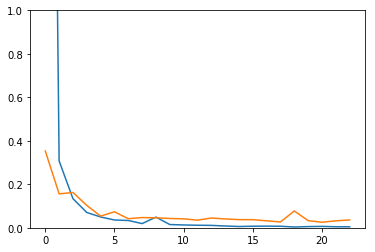

In [46]:

loss_list = fit_result.__dict__['history']['loss']
val_loss_list = fit_result.__dict__['history']['val_loss']

# print(loss_epoch_dict)
# print(val_loss_epoch_dict)

fig = plt.figure()
plt.plot(list(range(len(loss_list))), loss_list)
plt.plot(list(range(len(val_loss_list))), val_loss_list)
plt.ylim(0, 1)
# plt.show()
# help(plt.plot)


In [158]:
# X_test = X_valid
# Y_test = Y_valid

In [65]:
X_tensor_test = paths_to_tensor(X_test, img_w, img_h)

In [66]:
model = get_Model(training=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 300, 64, 1)   0                                            
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 300, 64, 64)  640         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 300, 64, 64)  256         conv2[0][0]                      
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 300, 64, 64)  0           batch_normalization_106[0][0]    
__________________________________________________________________________________________________
max1 (MaxP

In [64]:
model.load_weights('./checkpoint/CRNN--20--0.033.hdf5')

In [67]:
import itertools
out_tensor = model.predict(X_tensor_test)
def out_tensor_to_expression(out_tensor):
    Y_pred = list()
    for tensor in out_tensor:
        out_tensor_argmax = np.argmax(tensor, axis=1)
        out_best = [k for k, g in itertools.groupby(out_tensor_argmax)]
        out_best = list(filter(lambda x: x < 16, out_best))
        Y_pred.append(labels_to_expression(out_best))
    return Y_pred

Y_pred = np.array(out_tensor_to_expression(out_tensor))

In [122]:
tt = np.argmax(out_tensor[3], axis=1)
print(tt)
print(Y_test[3])

[ 0 16 16 16 16 16 16 16 16 16 16 13 13 10  4 12  7 11 11 11 15 15 15 15
 15 15 15 15 15 15 15 13 13  1  1 16  1]
0-(4+7)=-11


In [63]:
total = 0
acc = 0

letter_total = 0
letter_acc = 0

err_pre_indexs = list()
for pre, true in zip(Y_pred, Y_test):
#     print('pre: ', pre, '\t true: ', true)
    for i in range(min(len(pre), len(true))):
        if pre[i] == true[i]:
            letter_acc += 1
    letter_total += max(len(pre), len(true))
    if pre == true:
        acc += 1
    else:
        err_pre_indexs.append(total)
#         print('**** occur error prediction ****')
    total += 1


print('letter accuracy: %.4f' % (letter_acc / float(letter_total)))
print('total  accuracy: %.4f' % (acc / total)) 

letter accuracy: 0.0241
total  accuracy: 0.0000


In [52]:
print('error prediction indexs: ', err_pre_indexs)
print('error cases:')
for i in err_pre_indexs:
    print('pre: ', Y_pred[i], '\t true: ', Y_test[i])

error prediction indexs:  [201, 263, 407, 571, 841, 907, 1052, 1541, 1600, 1614, 1653, 1659, 1722, 2481, 2501, 2516, 2757, 3077, 3247, 3282, 3427, 3479, 4052, 4361, 4585]
error cases:
pre:  9+6+8=15 	 true:  9+6+0=15
pre:  4*5-3=11 	 true:  4*5-3=17
pre:  4+(9*7)=13 	 true:  4+(9*1)=13
pre:  7*9*8=584 	 true:  7*9*8=504
pre:  9*9*7=81 	 true:  9*9*1=81
pre:  9*(7+2)=27 	 true:  9*(1+2)=27
pre:  (5-4)*7=-7 	 true:  (5-4)*7=7
pre:  0+6+7=7 	 true:  0+6+1=7
pre:  5*5+7=37 	 true:  5*6+7=37
pre:  1*(7-0)=6 	 true:  1*(6-0)=6
pre:  (4+6)*7=10 	 true:  (4+6)*1=10
pre:  1*(5+6)=1 	 true:  1*(5+6)=11
pre:  2-(8-1)=-6 	 true:  1-(8-1)=-6
pre:  (7+9)-1=14 	 true:  (7+9)-2=14
pre:  7+(9-3)=7 	 true:  1+(9-3)=7
pre:  1*1-0=4 	 true:  1*4-0=4
pre:  (6+3)*7=9 	 true:  (6+3)*1=9
pre:  (1-9)*9=-12 	 true:  (1-9)*9=-72
pre:  (7-2)+1=5 	 true:  (7-2)+0=5
pre:  1*(2+1)=9 	 true:  1*(2+7)=9
pre:  (1+7)+8=10 	 true:  (1+1)+8=10
pre:  (2*1)+1=15 	 true:  (2*7)+1=15
pre:  (6-1)-0=5 	 true:  (6-1)+0=5
pre:  (

In [53]:
%matplotlib inline

def visualize_error_img(img_path, ax):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300, 64))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_error_cases(paths, pre_labels, true_labels):
    inner_len = len(paths)
    columns = 4
    rows = int(inner_len - 1 / columns) + 1
    fig = plt.figure(figsize=(20, 2 * rows))
    for i in range(inner_len):
        label = 'true:%s \npre:%s' % (true_labels[i],pre_labels[i])
        ax = fig.add_subplot(rows,columns, i+1,xticks=[],yticks=[], title=label)
        visualize_error_img(paths[i], ax)

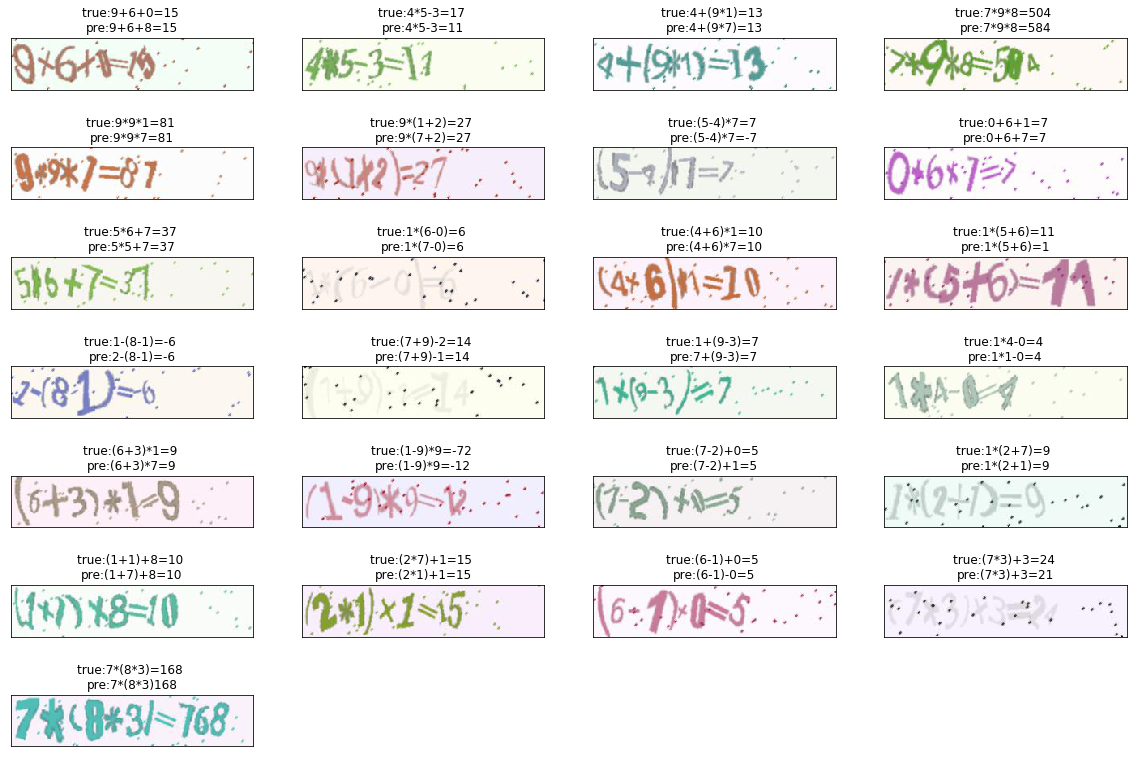

In [54]:
error_paths = list()
error_preds = list()
error_trues = list()
for i in err_pre_indexs:
    error_paths.append(X_test[i])
    error_preds.append(Y_pred[i])
    error_trues.append(Y_test[i])

show_error_cases(error_paths, error_preds, error_trues)
